# Cleaning EPC data

Copyright 2023 Fulvio Re Cecconi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License .
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied .
See the License for the specific language governing permissions and
limitations under the License .

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import needed libraries
import scipy
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import weibull_min
import pandas as pd
import math
import matplotlib.pyplot as plt
import time

In [3]:
# read hospitals dataset
df = pd.read_csv('/content/drive/MyDrive/2023_EC3_SummerSchoolData/SeparateDS/c1_hospitals.csv')

Exploratory data analysis

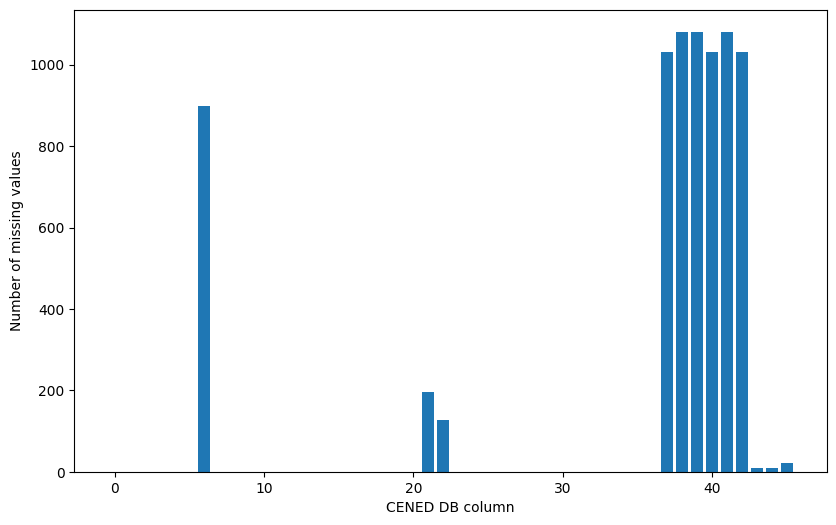

In [4]:
# plotting the number of missing values for each feature/column of the database
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size))
plt.bar(range(df.shape[1]),df.isna().sum())
plt.xlabel('CENED DB column')
plt.ylabel('Number of missing values')
plt.show()

In [5]:
# compute mean and standard deviation for each error type
# Error 1 - Gross Volume in m3
print('VOLUME_LORDO') # 'VOLUME_LORDO_RISCALDATO' in CENED 2
print('mean', np.mean(df.VOLUME_LORDO))
print('Std dev', np.std(df.VOLUME_LORDO))
# Error 2 - Gross heated surface
print('SUPERFICIE_LORDA') # 'SUPERF_UTILE_RISCALDATA' in CENED 2
print('mean', np.mean(df.SUPERFICIE_LORDA))
print('Std dev', np.std(df.SUPERFICIE_LORDA))
# Error 3 - gross volume / gross heated surface, i.e. average height
# adding a column with the volume-surface ratio
df['H_MEDIA'] = df.VOLUME_LORDO / df.SUPERFICIE_LORDA
print('H_MEDIA')
print('mean', np.mean(df.H_MEDIA))
print('Std dev', np.std(df.H_MEDIA))
# Error 4
# In CENED 1.2 there is no column with the ratio of envelope surface to volume which is a very important factor for energy consumption,
# I am adding a column and calculating it
df['RAPPORTO_SV'] = df.SUPERFICIE_DISPERDENTE / df.VOLUME_LORDO
print('RAPPORTO_SV')
print('mean', np.mean(df.RAPPORTO_SV))
print('Std dev', np.std(df.RAPPORTO_SV))
# Error 5 - average walls transmittance
print('TRASMITTANZA_MEDIA_INVOLUCRO')
print('mean', np.mean(df.TRASMITTANZA_MEDIA_INVOLUCRO))
print('Std dev', np.std(df.TRASMITTANZA_MEDIA_INVOLUCRO))
# Error 6 - average roofs transmittance
print('TRASMITTANZA_MEDIA_COPERTURA')
print('mean', np.mean(df.TRASMITTANZA_MEDIA_COPERTURA))
print('Std dev', np.std(df.TRASMITTANZA_MEDIA_COPERTURA))
# Error 7 - average windows transmittance
print('TRASMITTANZA_MEDIA_SERRAMENTO')
print('mean', np.mean(df.TRASMITTANZA_MEDIA_SERRAMENTO))
print('Std dev', np.std(df.TRASMITTANZA_MEDIA_SERRAMENTO))
# Error 8  - primary energy demand
print('EPH')
print('mean', np.mean(df.EPH))
print('Std dev', np.std(df.EPH))

VOLUME_LORDO
mean 14291.741452489454
Std dev 40922.3665193084
SUPERFICIE_LORDA
mean 3589.6269875949365
Std dev 8481.213303653527
H_MEDIA
mean 3.8324269004442204
Std dev 1.6029467443131868
RAPPORTO_SV
mean 0.5055753485254311
Std dev 0.21039297991962488
TRASMITTANZA_MEDIA_INVOLUCRO
mean 0.9556718987341771
Std dev 0.5849971477980366
TRASMITTANZA_MEDIA_COPERTURA
mean 0.9448191295546559
Std dev 0.6281285675697437
TRASMITTANZA_MEDIA_SERRAMENTO
mean 2.9303058227848098
Std dev 1.2877184224965417
EPH
mean 44.603151814345985
Std dev 39.690466793949426


In [6]:
# statistical description of the data
df.describe()

,Unnamed: 0,CODICE_IDENTIFICATIVO_PRATICA,SUPERFICIE_LORDA,SUPERFICIE_NETTA,VOLUME_LORDO,VOLUME_NETTO,SUPERFICIE_DISPERDENTE,SUPERFICIE_VETRATA_OPACA,TRASMITTANZA_MEDIA_INVOLUCRO,TRASMITTANZA_MEDIA_COPERTURA,...,EMISSIONI_DI_CO2,EPW,EPT,EF_GLOB_MEDIA_RISCALDAMENTO,EF_GLOB_MEDIA_ACQUA_CALDA_SAN,EGHW,SUPERFICIE_APERTURA_ST,SUP_PAN_ST_SUP_UTILE,H_MEDIA,RAPPORTO_SV
count,1.185000e+03,1.185000e+03,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,988.000000,...,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,153.000000,153.000000,1185.000000,1185.000000
mean,7.715079e+05,2.332626e+12,3589.626988,3146.262465,14291.741452,10165.712497,4648.114861,0.105611,0.955672,0.944819,...,8.836700,32.878310,77.481461,1.012118,1.737899,0.743156,36.309817,0.023007,3.832427,0.505575
std,4.425835e+05,2.448399e+12,8484.794141,7548.677415,40939.644277,24341.024557,9275.468811,0.087537,0.585244,0.628447,...,7.966513,125.650038,131.174742,1.243988,43.892682,0.541810,55.340934,0.074089,1.603624,0.210482
min,8.410000e+02,1.200100e+12,12.510000,8.700000,34.945000,23.490000,21.750000,0.007600,0.000000,0.030000,...,0.064200,0.000000,2.558200,0.070000,0.000000,0.020000,0.560000,0.000000,1.408321,0.080026
25%,3.949260e+05,1.514600e+12,254.120000,216.097600,986.920000,676.350000,568.060000,0.062000,0.445000,0.331125,...,3.616500,3.285900,31.048600,0.640000,0.090000,0.500000,6.800000,0.008000,3.390061,0.354684
50%,7.919410e+05,1.604300e+12,953.400000,818.450000,3743.530000,2651.540000,1805.133400,0.084800,0.903300,0.797200,...,7.704800,8.739200,54.805900,0.750000,0.300000,0.670000,18.480000,0.012000,3.667578,0.469667
75%,1.149229e+06,1.811000e+12,3336.000000,2949.470000,13053.670000,9240.660000,4934.861000,0.125000,1.320900,1.483325,...,11.856700,22.538100,81.164200,0.910000,0.600000,0.800000,43.200000,0.022000,4.023865,0.632531
max,1.515988e+06,1.080500e+13,148840.510000,132036.840000,711667.910000,384322.180000,145551.300000,1.648600,3.119500,5.263000,...,138.762900,2017.382300,2080.414000,24.090000,1510.370000,7.040000,425.000000,0.911000,50.468917,2.416290


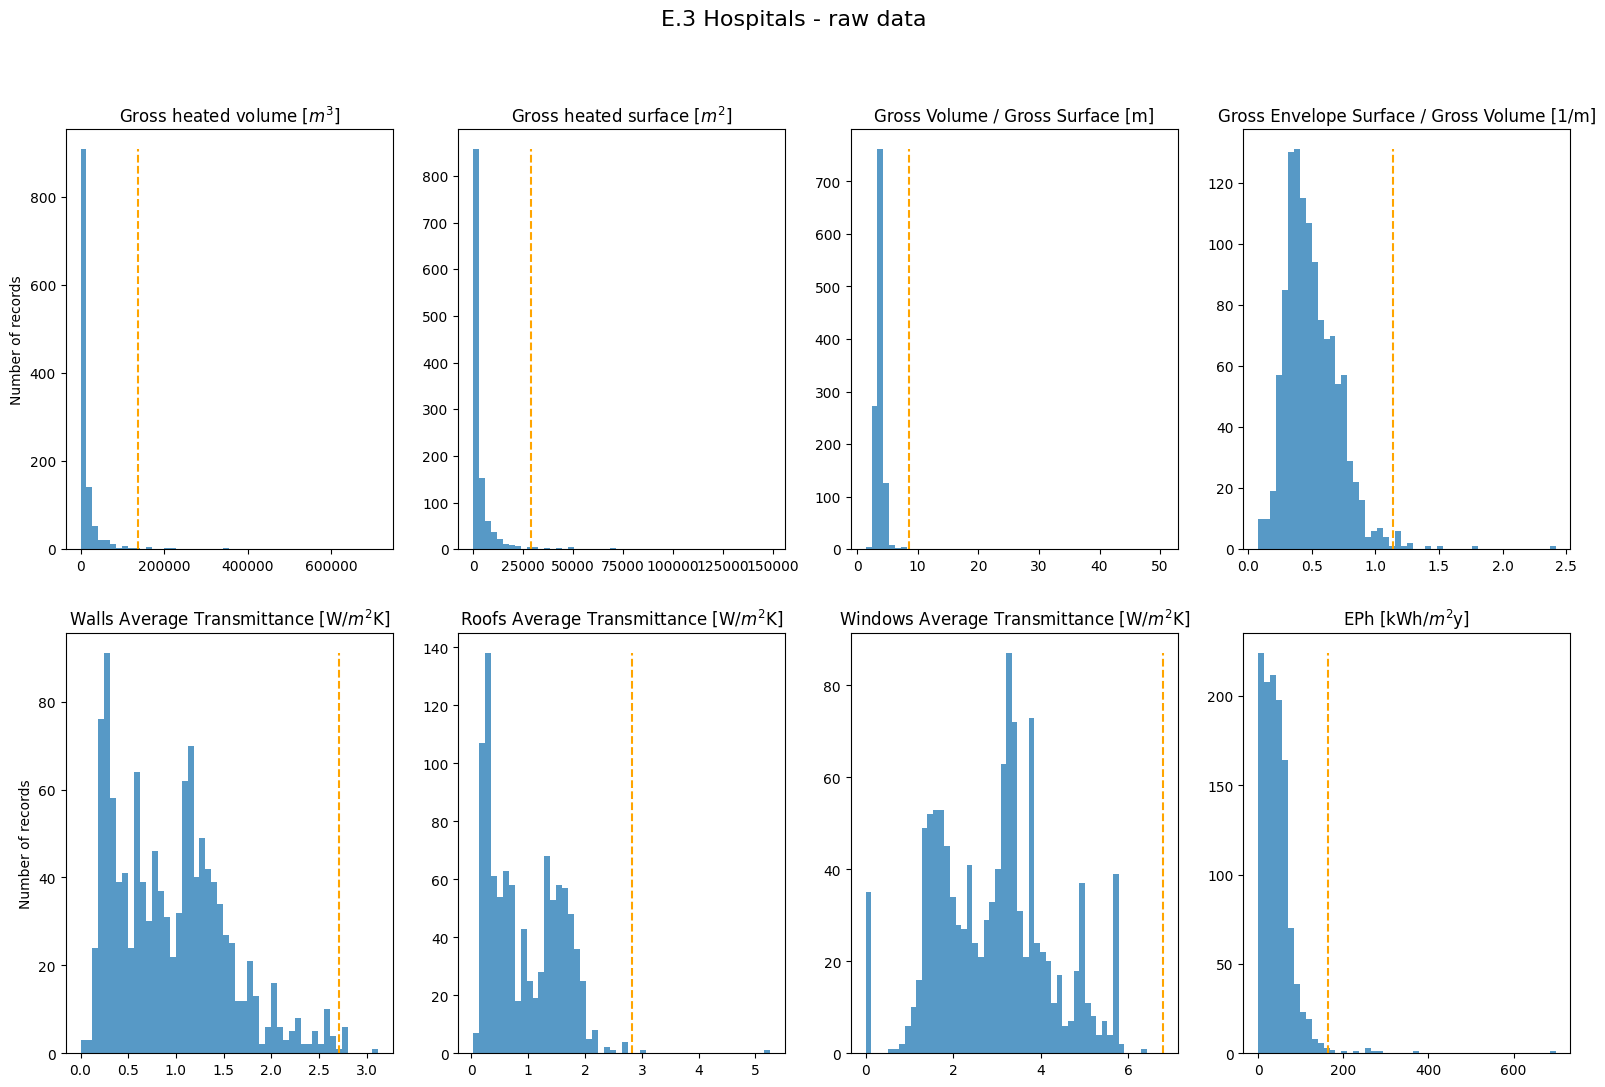

In [7]:
# plotting the raw data
figure_size = 12
fig, axs = plt.subplots(2, 4, figsize=(figure_size * 1.618, figure_size))
fig.suptitle('E.3 Hospitals - raw data', fontsize=16)

# gross volume
n, bins, patches = axs[0, 0].hist([df['VOLUME_LORDO']], 50, density=False, alpha=0.75)
v_mean = np.mean(df.VOLUME_LORDO)
v_stddev = np.std(df.VOLUME_LORDO)
line_x = np.array([v_mean + 3 * v_stddev, v_mean + 3 * v_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 0].plot(line_x, line_y, ls = '--', c='orange')
if (v_mean - 3 * v_stddev) > 0:
  line_x = np.array([v_mean - 3 * v_stddev, v_mean - 3 * v_stddev])
  axs[0, 0].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 0].set_title('Gross heated volume [$m^3$]')
axs[0, 0].set_ylabel('Number of records')

# gross surface
n, bins, patches = axs[0, 1].hist([df['SUPERFICIE_LORDA']], 50, density=False, alpha=0.75)
s_mean = np.mean(df.SUPERFICIE_LORDA)
s_stddev = np.std(df.SUPERFICIE_LORDA)
line_x = np.array([s_mean + 3 * s_stddev, s_mean + 3 * s_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 1].plot(line_x, line_y, ls = '--', c='orange')
if (s_mean - 3 * s_stddev) > 0:
  line_x = np.array([s_mean - 3 * s_stddev, s_mean - 3 * s_stddev])
  axs[0, 1].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 1].set_title('Gross heated surface [$m^2$]')

# average height
n, bins, patches = axs[0, 2].hist([df['H_MEDIA']], 50, density=False, alpha=0.75)
h_mean = np.mean(df.H_MEDIA)
h_stddev = np.std(df.H_MEDIA)
line_x = np.array([h_mean + 3 * h_stddev, h_mean + 3 * h_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 2].plot(line_x, line_y, ls = '--', c='orange')
if (h_mean - 3 * h_stddev) > 0:
  line_x = np.array([h_mean - 3 * h_stddev, h_mean - 3 * h_stddev])
  axs[0, 2].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 2].set_title('Gross Volume / Gross Surface [m]')

# S/V ratio
n, bins, patches = axs[0, 3].hist([df['RAPPORTO_SV']], 50, density=False, alpha=0.75)
sv_mean = np.mean(df.RAPPORTO_SV)
sv_stddev = np.std(df.RAPPORTO_SV)
line_x = np.array([sv_mean + 3 * sv_stddev, sv_mean + 3 * sv_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 3].plot(line_x, line_y, ls = '--', c='orange')
if (sv_mean - 3 * sv_stddev) > 0:
  line_x = np.array([sv_mean - 3 * sv_stddev, sv_mean - 3 * sv_stddev])
  axs[0, 3].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 3].set_title('Gross Envelope Surface / Gross Volume [1/m]')

# average walls transmittance
n, bins, patches = axs[1, 0].hist([df['TRASMITTANZA_MEDIA_INVOLUCRO']], 50, density=False, alpha=0.75)
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_INVOLUCRO)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_INVOLUCRO)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 0].plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  axs[1, 0].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 0].set_title('Walls Average Transmittance [W/$m^2$K]')
axs[1, 0].set_ylabel('Number of records')

# average roofs transmittance
n, bins, patches = axs[1, 1].hist([df['TRASMITTANZA_MEDIA_COPERTURA']], 50, density=False, alpha=0.75)
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_COPERTURA)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_COPERTURA)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 1].plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  axs[1, 1].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 1].set_title('Roofs Average Transmittance [W/$m^2$K]')

# average windows transmittance
n, bins, patches = axs[1, 2].hist([df['TRASMITTANZA_MEDIA_SERRAMENTO']], 50, density=False, alpha=0.75)
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_SERRAMENTO)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_SERRAMENTO)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 2].plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  axs[1, 2].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 2].set_title('Windows Average Transmittance [W/$m^2$K]')

# Primary energy demand
n, bins, patches = axs[1, 3].hist([df['EPH']], 50, density=False, alpha=0.75)
ep_mean = np.mean(df.EPH)
ep_stddev = np.std(df.EPH)
line_x = np.array([ep_mean + 3 * ep_stddev, ep_mean + 3 * ep_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 3].plot(line_x, line_y, ls = '--', c='orange')
if (ep_mean - 3 * ep_stddev) > 0:
  line_x = np.array([ep_mean - 3 * ep_stddev, ep_mean - 3 * ep_stddev])
  axs[1, 3].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 3].set_title('EPh [kWh/$m^2$y]')

# fig.savefig('/content/drive/MyDrive/2023_EC3_SummerSchoolData/HospitalsDataQuality.pdf', dpi=300)
fig.show()

# Cleaning the data

# Error 1

In [8]:
# deleting elements with a heated gross volume less than 27 (10*2.7) and greater than 25000
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.VOLUME_LORDO < 27 )].index, inplace=True)
print('Deleted',vol_start - len(df), 'too small records')
df.drop(df[(df.VOLUME_LORDO > 25000 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Starting with 1185 records
Deleted 0 too small records
Ending with 1031 records
Deleted 154 records out of 1185 equal to -12.9958 %


In [9]:
# counting the outlier, i.e. v > mean + 3*stddev and v < mean + 3*stddev
v_mean = np.mean(df.VOLUME_LORDO)
v_stddev = np.std(df.VOLUME_LORDO)
print('Min:', np.min(df.VOLUME_LORDO))
print('Max:', np.max(df.VOLUME_LORDO))
print('lim:', v_mean + 3*v_stddev)
print('n° upper outlier', len(df.loc[df['VOLUME_LORDO'] >= v_mean + 3*v_stddev]))
print('n° lower outlier', len(df.loc[df['VOLUME_LORDO'] <= v_mean - 3*v_stddev]))

Min: 34.945
Max: 24965.249
lim: 23462.094710766924
n° upper outlier 12
n° lower outlier 0


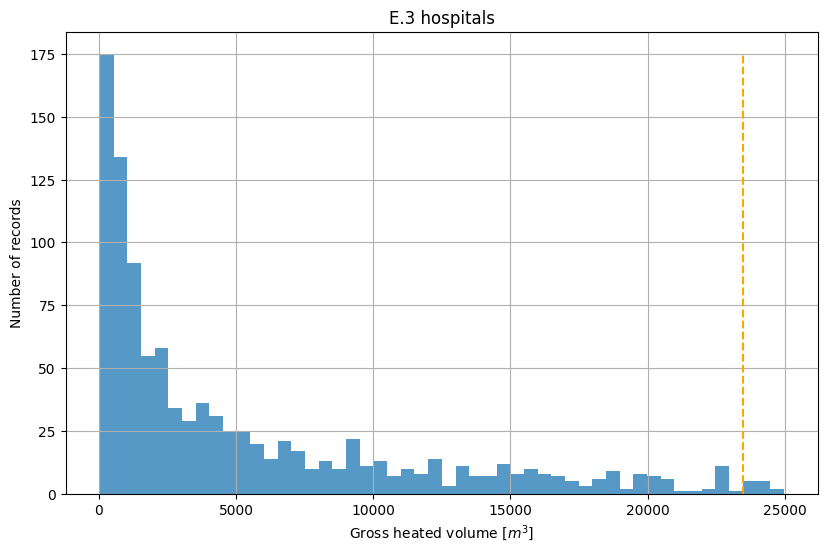

In [10]:
# heated gross volume graph
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size))
# the histogram of the data
n, bins, patches = plt.hist([df['VOLUME_LORDO']], 50, density=False, alpha=0.75)
line_x = np.array([v_mean + 3 * v_stddev, v_mean + 3 * v_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (v_mean - 3 * v_stddev) > 0:
  line_x = np.array([v_mean - 3 * v_stddev, v_mean - 3 * v_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('Gross heated volume [$m^3$]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Error 2

In [11]:
# deleting records with gross heated surface smaller than 10 m2 or bigger than 25000
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.SUPERFICIE_LORDA < 10 )].index, inplace=True)
print('Deleted',vol_start - len(df), 'too small records')
df.drop(df[(df.SUPERFICIE_LORDA > 10000)].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',
      round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Starting with 1031 records
Deleted 0 too small records
Ending with 1031 records
Deleted 0 records out of 1031 equal to 0.0 %


In [12]:
# outlier, i.e. s > mean + 3*stddev or s < mean + 3*stddev
s_mean = np.mean(df.SUPERFICIE_LORDA)
s_stddev = np.std(df.SUPERFICIE_LORDA)
print('Min:', np.min(df.SUPERFICIE_LORDA))
print('Max:', np.max(df.SUPERFICIE_LORDA))
print('lim:', s_mean + 3 * s_stddev)
print('n° outlier sup', len(df.loc[df['SUPERFICIE_LORDA'] >= s_mean + 3 * s_stddev]))
print('n° outlier inf', len(df.loc[df['SUPERFICIE_LORDA'] <= s_mean - 3 * s_stddev]))

Min: 12.51
Max: 7326.04
lim: 6286.83074666531
n° outlier sup 11
n° outlier inf 0


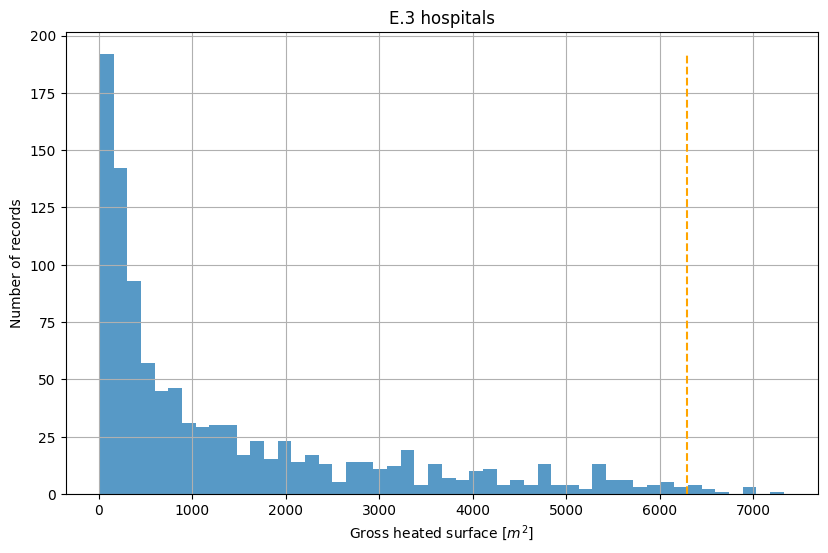

In [13]:
# gross heated surface graph
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size))
# the histogram of the data
n, bins, patches = plt.hist([df['SUPERFICIE_LORDA']], 50, density=False, alpha=0.75)
line_x = np.array([s_mean + 3 * s_stddev, s_mean + 3 * s_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (s_mean - 3 * s_stddev) > 0:
  line_x = np.array([s_mean - 3 * s_stddev, s_mean - 3 * s_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('Gross heated surface [$m^2$]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Error 3

In [14]:
# deleting records with average height lower than 2.5 or higher than 10
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.H_MEDIA < 2.5 )].index, inplace=True)
df.drop(df[(df.H_MEDIA > 10 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Starting with 1031 records
Ending with 1023 records
Deleted 8 records out of 1031 equal to -0.7759 %


In [15]:
# outlier, i.e. h > mean + 3*stddev or h < mean + 3*stddev
h_mean = np.mean(df.H_MEDIA)
h_stddev = np.std(df.H_MEDIA)
print('Min:', np.min(df.H_MEDIA))
print('Max:', np.max(df.H_MEDIA))
print('lim:', h_mean + 3 * h_stddev)
print('n° outlier sup', len(df.loc[df['H_MEDIA'] >= h_mean + 3 * h_stddev]))
print('n° outlier inf', len(df.loc[df['H_MEDIA'] <= h_mean - 3 * h_stddev]))

Min: 2.5344618610478946
Max: 7.5
lim: 5.514945848881998
n° outlier sup 12
n° outlier inf 0


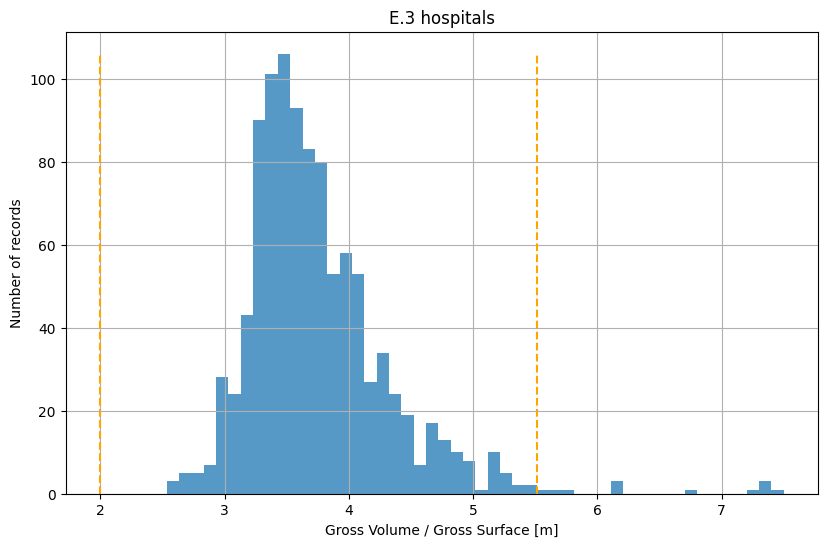

In [16]:
# graphing the average height
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# the histogram of the data
n, bins, patches = plt.hist([df['H_MEDIA']], 50, density=False, alpha=0.75)
line_x = np.array([h_mean + 3 * h_stddev, h_mean + 3 * h_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (h_mean - 3 * h_stddev) > 0:
  line_x = np.array([h_mean - 3 * h_stddev, h_mean - 3 * h_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('Gross Volume / Gross Surface [m]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Error 4

In [17]:
# Envelope surface / Volume ratio (called S/V)
# deleting records with S/V <=0 or S/V > (mean + 3 * standard deviation)
sv_mean = np.mean(df.RAPPORTO_SV)
sv_stddev = np.std(df.RAPPORTO_SV)
print('Upper limit', (sv_mean + 3 * sv_stddev))
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.RAPPORTO_SV > (sv_mean + 3 * sv_stddev) )].index, inplace=True)
df.drop(df[(df.RAPPORTO_SV <= 0 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Upper limit 1.146611723482785
Starting with 1023 records
Ending with 1011 records
Deleted 12 records out of 1023 equal to -1.173 %


In [18]:
# outlier, i.e. h > mean + 3*stddev or h < mean + 3*stddev
sv_mean = np.mean(df.RAPPORTO_SV)
sv_stddev = np.std(df.RAPPORTO_SV)
print('Min:', np.min(df.RAPPORTO_SV))
print('Max:', np.max(df.RAPPORTO_SV))
print('lim:', sv_mean + 3 * sv_stddev)
print('n° outlier sup', len(df.loc[df['RAPPORTO_SV'] >= sv_mean + 3 * sv_stddev]))
print('n° outlier inf', len(df.loc[df['RAPPORTO_SV'] <= sv_mean - 3 * sv_stddev]))

Min: 0.09811292518555992
Max: 1.1326975117153983
lim: 1.0694255436490043
n° outlier sup 5
n° outlier inf 0


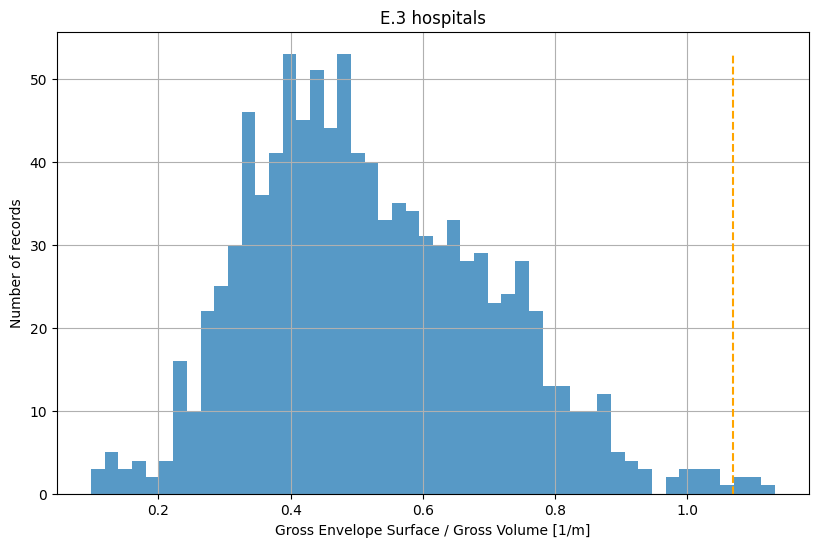

In [19]:
# S/V graph
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# the histogram of the data
n, bins, patches = plt.hist([df['RAPPORTO_SV']], 50, density=False, alpha=0.75)
line_x = np.array([sv_mean + 3 * sv_stddev, sv_mean + 3 * sv_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (sv_mean - 3 * sv_stddev) > 0:
  line_x = np.array([sv_mean - 3 * sv_stddev, sv_mean - 3 * sv_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('Gross Envelope Surface / Gross Volume [1/m]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Error 5

In [20]:
# deleting records with Average walls transmittance below 0 or above 4
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.TRASMITTANZA_MEDIA_INVOLUCRO >= 4 )].index, inplace=True)
df.drop(df[(df.TRASMITTANZA_MEDIA_INVOLUCRO < 0 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Starting with 1011 records
Ending with 1011 records
Deleted 0 records out of 1011 equal to 0.0 %


In [21]:
# outliers, i.e. > mean + 3*stddev or < mean + 3*stddev
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_INVOLUCRO)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_INVOLUCRO)
print('Min:', np.min(df.TRASMITTANZA_MEDIA_INVOLUCRO))
print('Max:', np.max(df.TRASMITTANZA_MEDIA_INVOLUCRO))
print('lim:', sv_mean + 3 * sv_stddev)
print('n° outlier sup', len(df.loc[df['TRASMITTANZA_MEDIA_INVOLUCRO'] >= yie_mean + 3 * yie_stddev]))
print('n° outlier inf', len(df.loc[df['TRASMITTANZA_MEDIA_INVOLUCRO'] <= yie_mean - 3 * yie_stddev]))

Min: 0.0
Max: 3.1195
lim: 1.0694255436490043
n° outlier sup 7
n° outlier inf 0


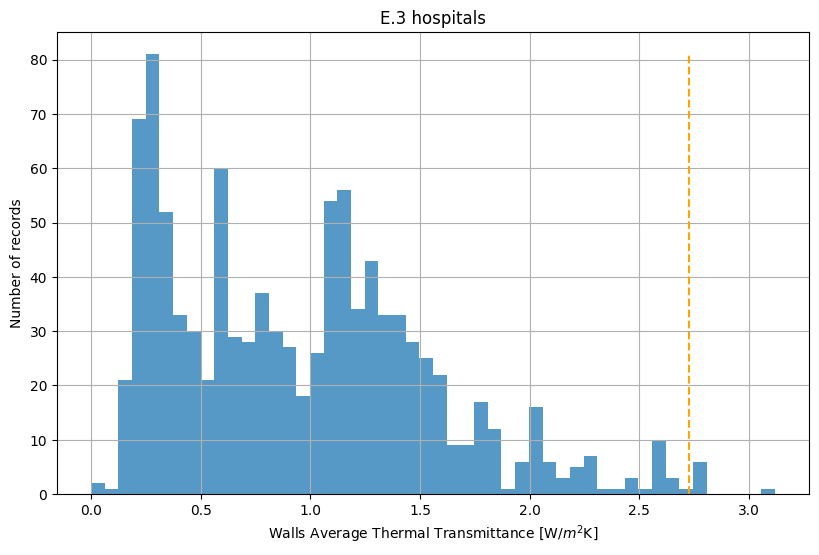

In [22]:
# Average walls transmittance graph
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# the histogram of the data
n, bins, patches = plt.hist([df['TRASMITTANZA_MEDIA_INVOLUCRO']], 50, density=False, alpha=0.75)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('Walls Average Thermal Transmittance [W/$m^2$K]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Error 6

In [23]:
# deleting records with Average roofs transmittance below 0 or above 4
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.TRASMITTANZA_MEDIA_COPERTURA >= 4 )].index, inplace=True)
df.drop(df[(df.TRASMITTANZA_MEDIA_COPERTURA < 0 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Starting with 1011 records
Ending with 1010 records
Deleted 1 records out of 1011 equal to -0.0989 %


In [24]:
# outliers, i.e. > mean + 3*stddev or < mean + 3*stddev
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_COPERTURA)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_COPERTURA)
print('Min:', np.min(df.TRASMITTANZA_MEDIA_COPERTURA))
print('Max:', np.max(df.TRASMITTANZA_MEDIA_COPERTURA))
print('lim:', sv_mean + 3 * sv_stddev)
print('n° outlier sup', len(df.loc[df['TRASMITTANZA_MEDIA_COPERTURA'] >= yie_mean + 3 * yie_stddev]))
print('n° outlier inf', len(df.loc[df['TRASMITTANZA_MEDIA_COPERTURA'] <= yie_mean - 3 * yie_stddev]))

Min: 0.03
Max: 3.0533
lim: 1.0694255436490043
n° outlier sup 1
n° outlier inf 0


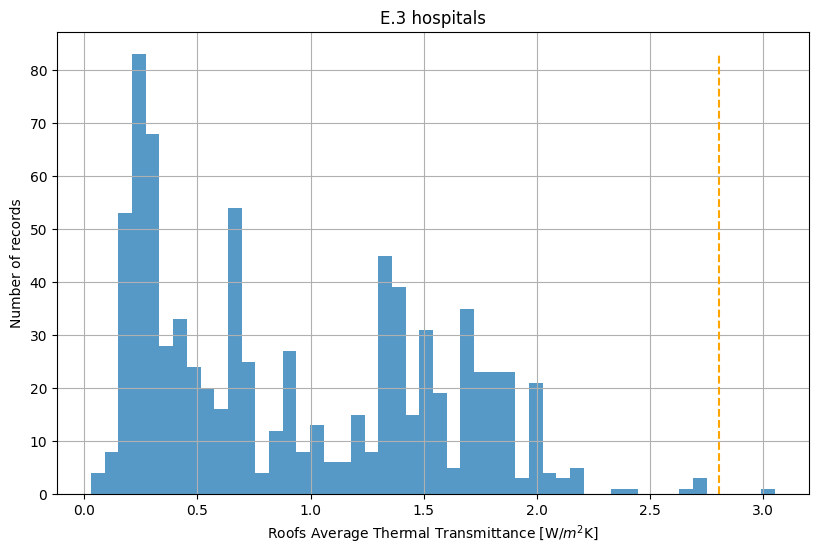

In [25]:
# Average roofs transmittance graph
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# the histogram of the data
n, bins, patches = plt.hist([df['TRASMITTANZA_MEDIA_COPERTURA']], 50, density=False, alpha=0.75)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('Roofs Average Thermal Transmittance [W/$m^2$K]')
plt.ylabel('Number of records')
# plt.yscale('log')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Error 7

In [26]:
# deleting records with Average windows transmittance below 0 or above 10
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.TRASMITTANZA_MEDIA_SERRAMENTO >= 10 )].index, inplace=True)
df.drop(df[(df.TRASMITTANZA_MEDIA_SERRAMENTO < 0 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Starting with 1010 records
Ending with 1010 records
Deleted 0 records out of 1010 equal to 0.0 %


In [27]:
# outliers, i.e. > mean + 3*stddev or < mean + 3*stddev
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_SERRAMENTO)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_SERRAMENTO)
print('Min:', np.min(df.TRASMITTANZA_MEDIA_SERRAMENTO))
print('Max:', np.max(df.TRASMITTANZA_MEDIA_SERRAMENTO))
print('lim:', sv_mean + 3 * sv_stddev)
print('n° outlier sup', len(df.loc[df['TRASMITTANZA_MEDIA_SERRAMENTO'] >= yie_mean + 3 * yie_stddev]))
print('n° outlier inf', len(df.loc[df['TRASMITTANZA_MEDIA_SERRAMENTO'] <= yie_mean - 3 * yie_stddev]))

Min: 0.0
Max: 5.9
lim: 1.0694255436490043
n° outlier sup 0
n° outlier inf 0


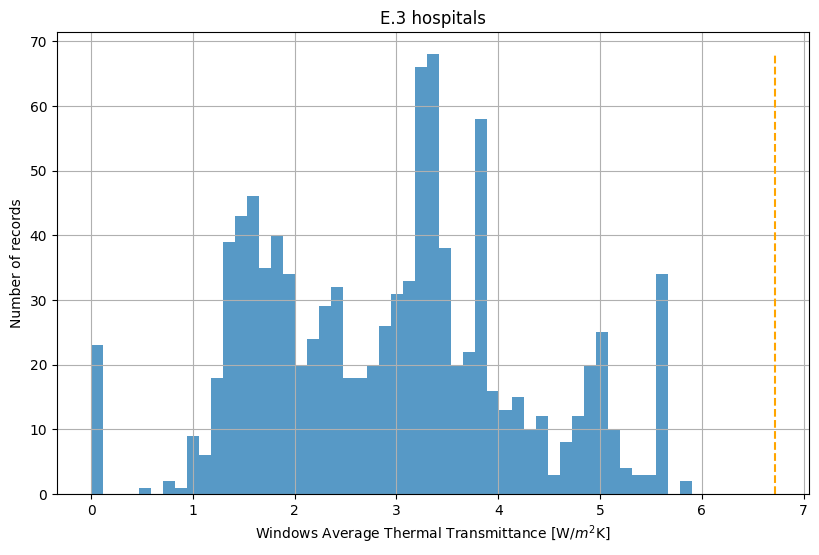

In [28]:
# Average windows transmittance graph
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# the histogram of the data
n, bins, patches = plt.hist([df['TRASMITTANZA_MEDIA_SERRAMENTO']], 50, density=False, alpha=0.75)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('Windows Average Thermal Transmittance [W/$m^2$K]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Error 8

In [29]:
# deleting record with primary energy demand (EPh) below 0 or above 800
vol_start = len(df)
print('Starting with',vol_start, 'records')
df.drop(df[(df.EPH > 800 )].index, inplace=True)
df.drop(df[(df.EPH < 0 )].index, inplace=True)
vol_end = len(df)
print('Ending with',vol_end, 'records')
print('Deleted', vol_start-vol_end, 'records out of', vol_start, 'equal to',round((vol_end-vol_start)/vol_start*10000,2)/100,'%')

Starting with 1010 records
Ending with 1010 records
Deleted 0 records out of 1010 equal to 0.0 %


In [30]:
# outlier, i.e. EPh > mean + 3*stddev or EPh < mean + 3*stddev
ep_mean = np.mean(df.EPH)
ep_stddev = np.std(df.EPH)
print('Min:', np.min(df.EPH))
print('Max:', np.max(df.EPH))
print('lim:', ep_mean + 3 * ep_stddev)
print('n° outlier sup', len(df.loc[df['EPH'] >= ep_mean + 3 * ep_stddev]))
print('n° outlier inf', len(df.loc[df['EPH'] <= ep_mean - 3 * ep_stddev]))

Min: 0.3231
Max: 370.8803
lim: 151.09742601413063
n° outlier sup 13
n° outlier inf 0


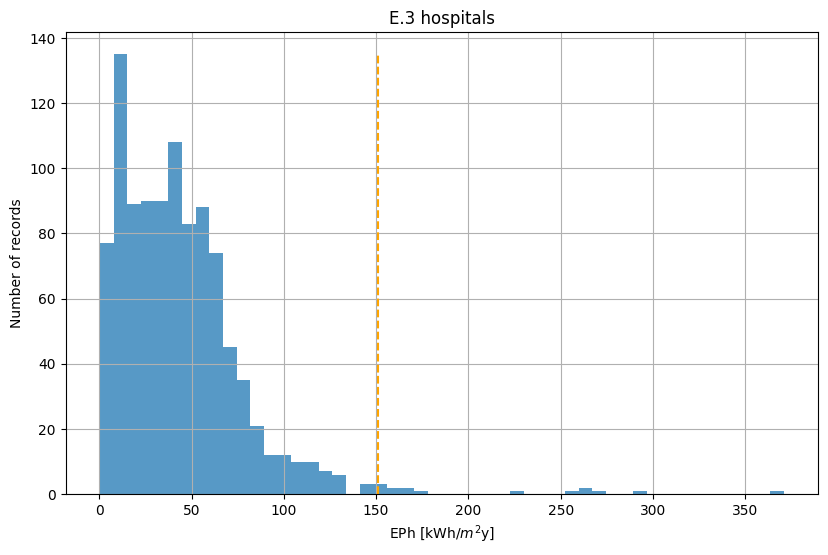

In [31]:
# EPh graph
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# the histogram of the data
n, bins, patches = plt.hist([df['EPH']], 50, density=False, alpha=0.75)
line_x = np.array([ep_mean + 3 * ep_stddev, ep_mean + 3 * ep_stddev])
line_y = np.array([0, np.max(n)])
plt.plot(line_x, line_y, ls = '--', c='orange')
if (ep_mean - 3 * ep_stddev) > 0:
  line_x = np.array([ep_mean - 3 * ep_stddev, ep_mean - 3 * ep_stddev])
  plt.plot(line_x, line_y, ls = '--', c='orange')
plt.xlabel('EPh [kWh/$m^2$y]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

# Controllo distribuzione per classe energetica dell'EPH

In [32]:
# build a list of Energy classes for further uses
classi_energetiche = df.CLASSE_ENERGETICA.unique()
classi_energetiche.sort()
print(classi_energetiche)

['A' 'A+' 'B' 'C' 'D' 'E' 'F' 'G']


In [33]:
# split data into a list of array according to the energy class
ep_classi = []
for classe in classi_energetiche:
  ep_classi.append(df.loc[df['CLASSE_ENERGETICA'] == classe].EPH)

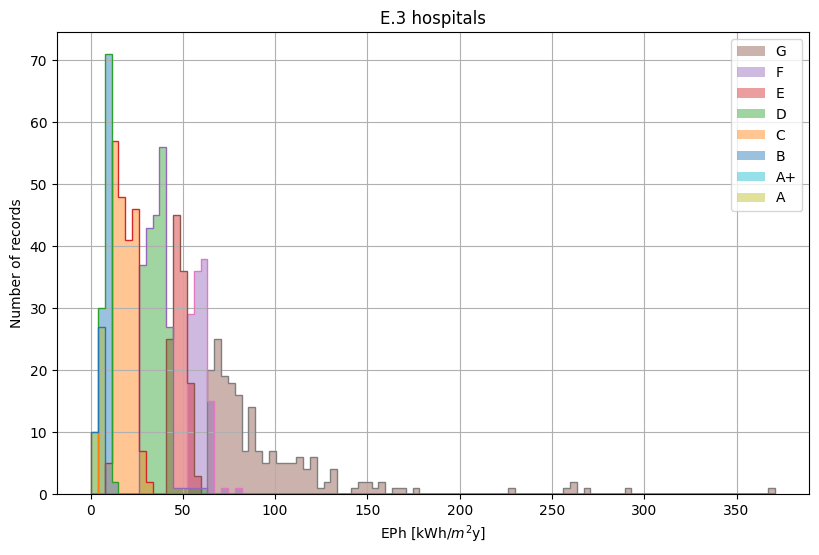

In [34]:
# plotting EPh and highlighting the energy classes
resolution = 100
figure_size = 6
fig = plt.figure(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# the histogram of the data
n, bins, patches = plt.hist(ep_classi, 100, density=False, alpha=1, histtype='step')
n, bins, patches = plt.hist(ep_classi, 100, density=False, alpha=0.45, label=classi_energetiche, histtype='stepfilled')
plt.legend(prop={'size': 10})
plt.xlabel('EPh [kWh/$m^2$y]')
plt.ylabel('Number of records')
plt.title('E.3 hospitals')
plt.grid(True)
plt.show()

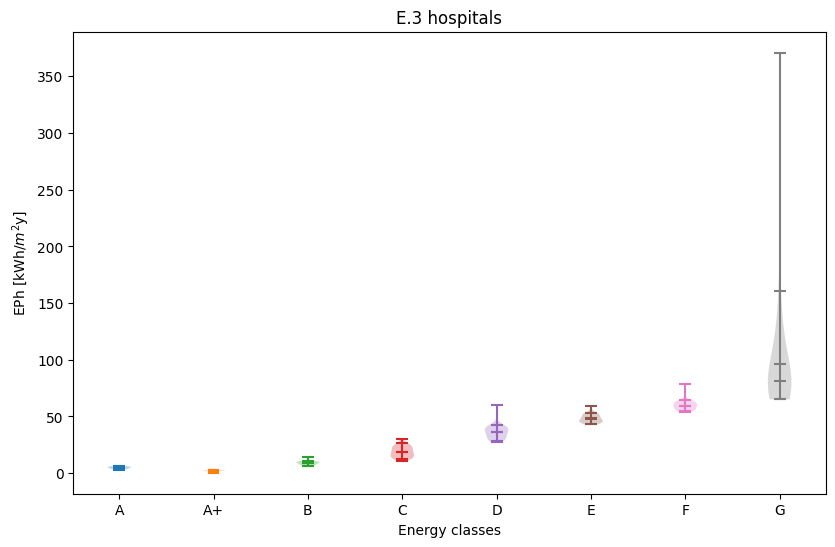

In [35]:
# violin plot of EPh for each energy class
resolution = 100
figure_size = 6
fig , ax = plt.subplots(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# violin plot of the data
pos = range(2,(len(classi_energetiche)+1)*2,2)
x = range(len(ep_classi))
for n in x:
    plt.violinplot(ep_classi[n], [2+2*n], showmeans=True,
                     showextrema=True, showmedians=True, bw_method=0.5, quantiles=[0.05, 0.95])
ax.set_xticks(pos)
ax.set_xticklabels(classi_energetiche)
plt.ylabel('EPh [kWh/$m^2$y]')
plt.xlabel('Energy classes')
plt.title('E.3 hospitals')
plt.show()

In [36]:
# split again data into a list of array according to the energy class after having removed quantiles 5% e 95%
ep_classi_rid = []
for ep in ep_classi:
  ep_classi_rid.append(ep[(ep >= np.quantile(ep, 0.05)) & (ep <= np.quantile(ep, 0.95))])

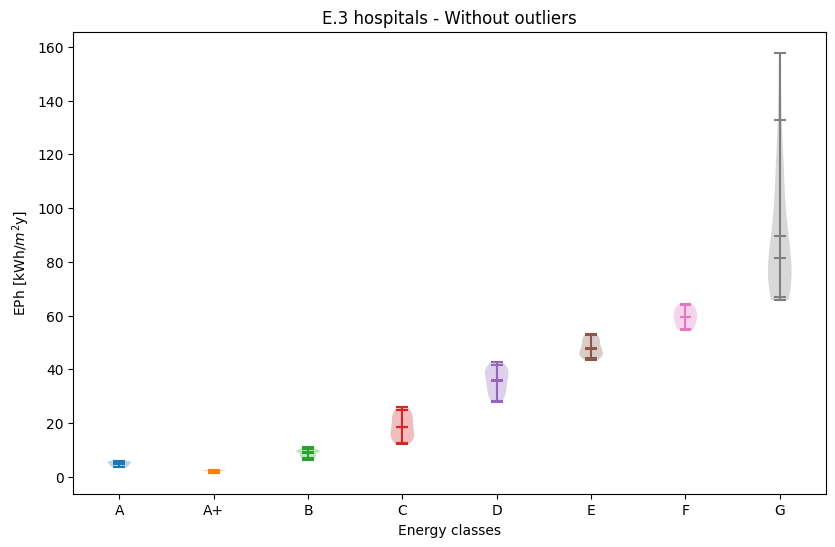

In [37]:
# violin plot of EPh for each energy class
resolution = 100
figure_size = 6
fig , ax = plt.subplots(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
# violin plot of the data
pos = range(2,(len(classi_energetiche)+1)*2,2)
x = range(len(ep_classi_rid))
for n in x:
    plt.violinplot(ep_classi_rid[n], [2+2*n], showmeans=True,
                     showextrema=True, showmedians=True, bw_method=0.5, quantiles=[0.05, 0.95])
ax.set_xticks(pos)
ax.set_xticklabels(classi_energetiche)
plt.ylabel('EPh [kWh/$m^2$y]')
plt.xlabel('Energy classes')
plt.title('E.3 hospitals - Without outliers')
plt.show()

In [38]:
# Computing how many records have been deleted
erased = []
x = range(len(ep_classi_rid))
for n in x:
  erased.append(len(ep_classi[n])-len(ep_classi_rid[n]))
print('Erased',np.sum(erased),'records')

Erased 106 records


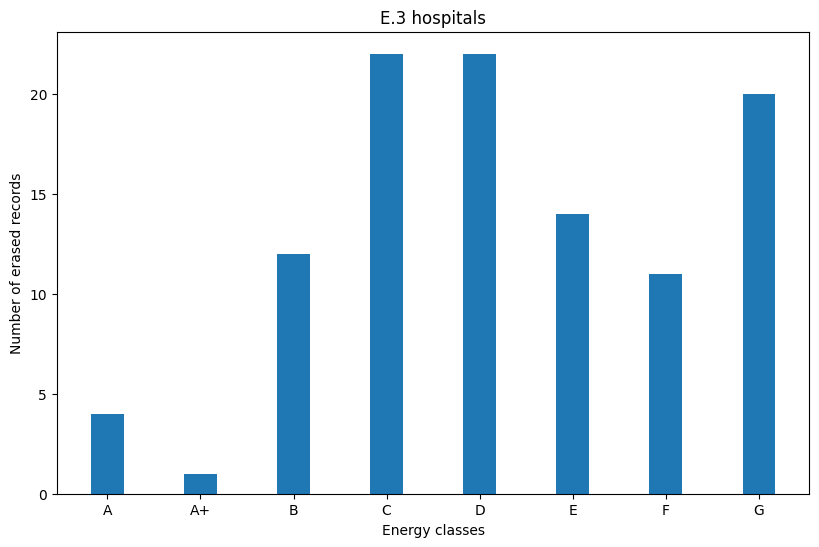

In [39]:
# erased record for each energy class
resolution = 100
figure_size = 6
x = np.arange(len(erased))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=resolution, figsize=(figure_size * 1.618, figure_size)) # 1.618 approssimazione del rapporto aureo
rects1 = ax.bar(x, erased, width)
ax.set_ylabel('Number of erased records')
plt.xlabel('Energy classes')
ax.set_title('E.3 hospitals')
ax.set_xticks(x)
ax.set_xticklabels(classi_energetiche)

plt.show()

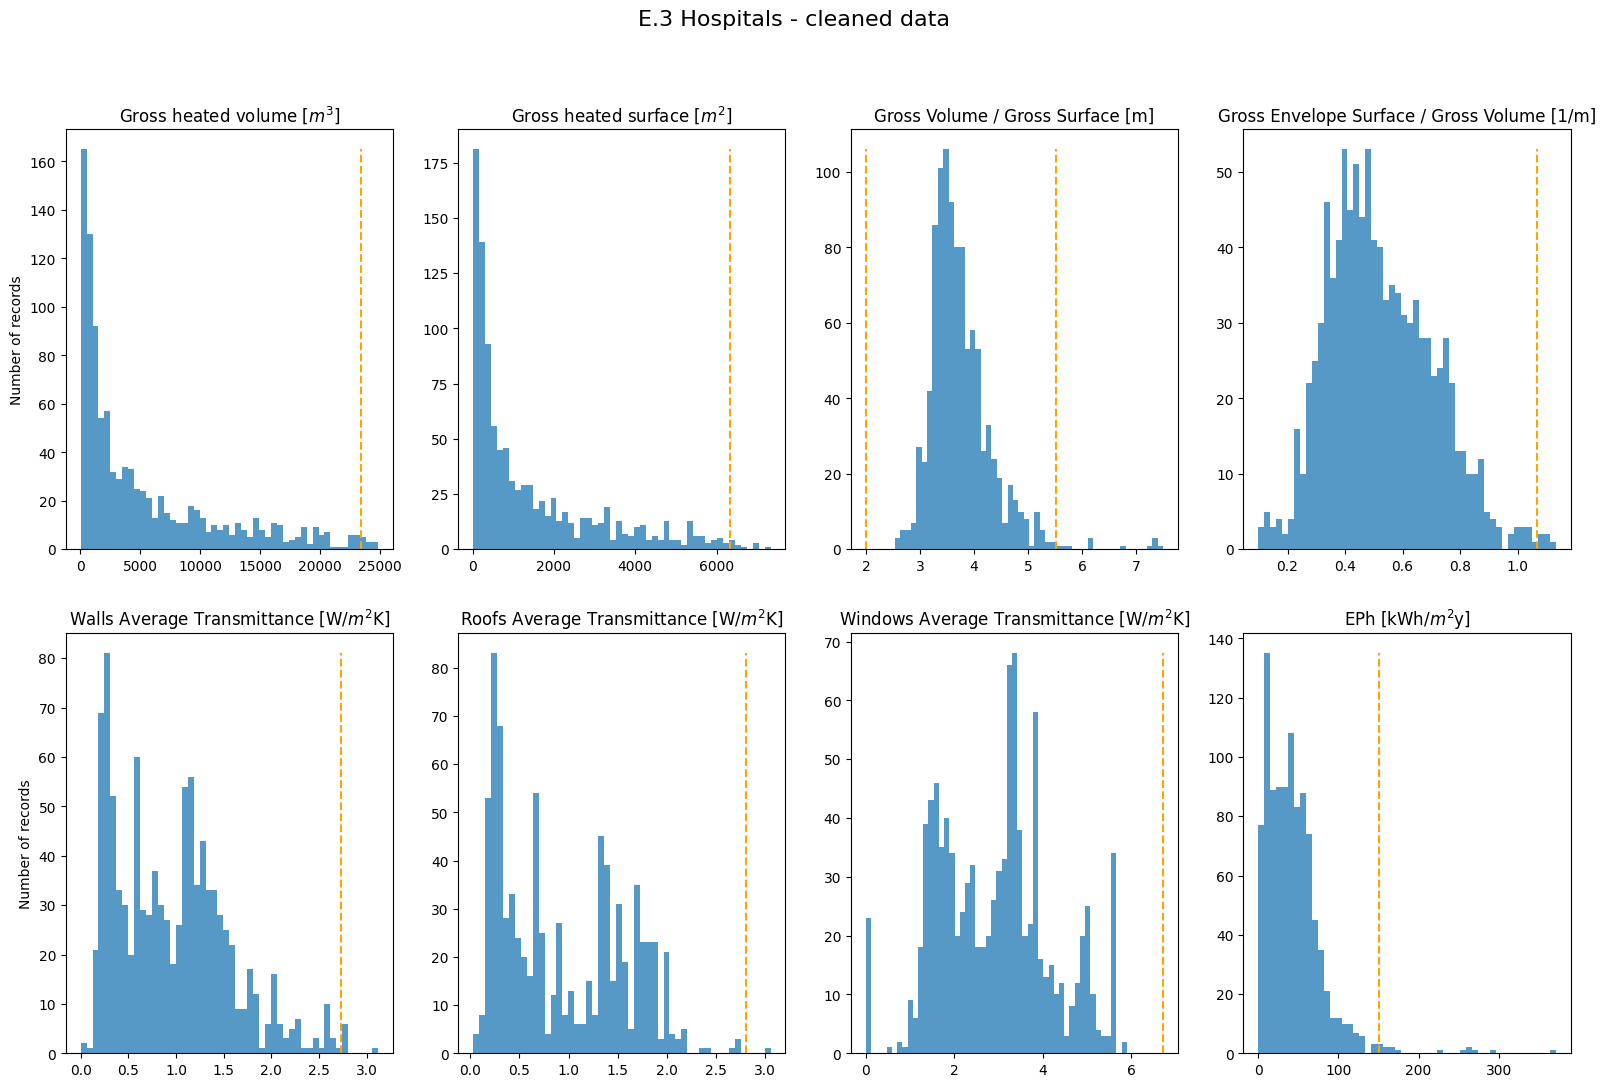

In [40]:
# plotting the cleaned data
figure_size = 12
fig, axs = plt.subplots(2, 4, figsize=(figure_size * 1.618, figure_size))
fig.suptitle('E.3 Hospitals - cleaned data', fontsize=16)

# gross volume
n, bins, patches = axs[0, 0].hist([df['VOLUME_LORDO']], 50, density=False, alpha=0.75)
v_mean = np.mean(df.VOLUME_LORDO)
v_stddev = np.std(df.VOLUME_LORDO)
line_x = np.array([v_mean + 3 * v_stddev, v_mean + 3 * v_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 0].plot(line_x, line_y, ls = '--', c='orange')
if (v_mean - 3 * v_stddev) > 0:
  line_x = np.array([v_mean - 3 * v_stddev, v_mean - 3 * v_stddev])
  axs[0, 0].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 0].set_title('Gross heated volume [$m^3$]')
axs[0, 0].set_ylabel('Number of records')

# gross surface
n, bins, patches = axs[0, 1].hist([df['SUPERFICIE_LORDA']], 50, density=False, alpha=0.75)
s_mean = np.mean(df.SUPERFICIE_LORDA)
s_stddev = np.std(df.SUPERFICIE_LORDA)
line_x = np.array([s_mean + 3 * s_stddev, s_mean + 3 * s_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 1].plot(line_x, line_y, ls = '--', c='orange')
if (s_mean - 3 * s_stddev) > 0:
  line_x = np.array([s_mean - 3 * s_stddev, s_mean - 3 * s_stddev])
  axs[0, 1].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 1].set_title('Gross heated surface [$m^2$]')

# average height
n, bins, patches = axs[0, 2].hist([df['H_MEDIA']], 50, density=False, alpha=0.75)
h_mean = np.mean(df.H_MEDIA)
h_stddev = np.std(df.H_MEDIA)
line_x = np.array([h_mean + 3 * h_stddev, h_mean + 3 * h_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 2].plot(line_x, line_y, ls = '--', c='orange')
if (h_mean - 3 * h_stddev) > 0:
  line_x = np.array([h_mean - 3 * h_stddev, h_mean - 3 * h_stddev])
  axs[0, 2].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 2].set_title('Gross Volume / Gross Surface [m]')

# S/V ratio
n, bins, patches = axs[0, 3].hist([df['RAPPORTO_SV']], 50, density=False, alpha=0.75)
sv_mean = np.mean(df.RAPPORTO_SV)
sv_stddev = np.std(df.RAPPORTO_SV)
line_x = np.array([sv_mean + 3 * sv_stddev, sv_mean + 3 * sv_stddev])
line_y = np.array([0, np.max(n)])
axs[0, 3].plot(line_x, line_y, ls = '--', c='orange')
if (sv_mean - 3 * sv_stddev) > 0:
  line_x = np.array([sv_mean - 3 * sv_stddev, sv_mean - 3 * sv_stddev])
  axs[0, 3].plot(line_x, line_y, ls = '--', c='orange')
axs[0, 3].set_title('Gross Envelope Surface / Gross Volume [1/m]')

# average walls transmittance
n, bins, patches = axs[1, 0].hist([df['TRASMITTANZA_MEDIA_INVOLUCRO']], 50, density=False, alpha=0.75)
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_INVOLUCRO)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_INVOLUCRO)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 0].plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  axs[1, 0].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 0].set_title('Walls Average Transmittance [W/$m^2$K]')
axs[1, 0].set_ylabel('Number of records')

# average roofs transmittance
n, bins, patches = axs[1, 1].hist([df['TRASMITTANZA_MEDIA_COPERTURA']], 50, density=False, alpha=0.75)
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_COPERTURA)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_COPERTURA)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 1].plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  axs[1, 1].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 1].set_title('Roofs Average Transmittance [W/$m^2$K]')

# average windows transmittance
n, bins, patches = axs[1, 2].hist([df['TRASMITTANZA_MEDIA_SERRAMENTO']], 50, density=False, alpha=0.75)
yie_mean = np.mean(df.TRASMITTANZA_MEDIA_SERRAMENTO)
yie_stddev = np.std(df.TRASMITTANZA_MEDIA_SERRAMENTO)
line_x = np.array([yie_mean + 3 * yie_stddev, yie_mean + 3 * yie_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 2].plot(line_x, line_y, ls = '--', c='orange')
if (yie_mean - 3 * yie_stddev) > 0:
  line_x = np.array([yie_mean - 3 * yie_stddev, yie_mean - 3 * yie_stddev])
  axs[1, 2].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 2].set_title('Windows Average Transmittance [W/$m^2$K]')

# Primary energy demand
n, bins, patches = axs[1, 3].hist([df['EPH']], 50, density=False, alpha=0.75)
ep_mean = np.mean(df.EPH)
ep_stddev = np.std(df.EPH)
line_x = np.array([ep_mean + 3 * ep_stddev, ep_mean + 3 * ep_stddev])
line_y = np.array([0, np.max(n)])
axs[1, 3].plot(line_x, line_y, ls = '--', c='orange')
if (ep_mean - 3 * ep_stddev) > 0:
  line_x = np.array([ep_mean - 3 * ep_stddev, ep_mean - 3 * ep_stddev])
  axs[1, 3].plot(line_x, line_y, ls = '--', c='orange')
axs[1, 3].set_title('EPh [kWh/$m^2$y]')

# fig.savefig('/content/drive/MyDrive/2023_EC3_SummerSchoolData/HospitalsDataQualityCleaned.pdf', dpi=300)
fig.show()